# 국민청원 데이터로 청원 카테고리 분류하기
### 기존 분류에 기타 카테고리를 다른 카테고리로 예측하는 코드 추가
### XGBoost로 예측 추가
* 청와대 국민청원 : https://www1.president.go.kr/petitions
* 학습세트의 카테고리를 바탕으로 테스트 세트의 청원 카테고리를 분류해 봅니다.
* `기타`로 설정된 카테고리를 텍스트 데이터로 예측해서 보정해 주고 다시 카테고리를 예측해 봅니다.

1. 데이터 전처리
1. 기타 청원과 아닌 것 나누기
    1. 단어 벡터화(BOW, TF-IDF)
    1. 기타 청원 분류하기(RF)
1. 예측값을 category_pred 컬럼에 넣어주기
1. 학습세트와 테스트세트를 7:3으로 임의로 나누기
1. 단어 벡터화(BOW, TF-IDF)
1. 분류기 설정하기(RF, XGB)
1. 분류기로 학습시키기(RF, XGB)
1. label 데이터를 예측한 category_pred 로 사용하기
1. 학습의 정확도 보기(RF, XGB)
1. 테스트 데이터 예측하기(RF, XGB)
1. 실제 데이터와 예측결과의 차이를 보기(RF, XGB)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [3]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(210424, 8)

In [4]:
petitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210424 entries, 0 to 210423
Data columns (total 8 columns):
article_id    210424 non-null int64
start         210424 non-null datetime64[ns]
end           210424 non-null datetime64[ns]
answered      210424 non-null int64
votes         210424 non-null int64
category      210424 non-null object
title         210424 non-null object
content       210423 non-null object
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 12.8+ MB


In [5]:
petitions.describe()

,article_id,answered,votes
count,210424.000000,210424.000000,210424.000000
mean,126356.643358,0.000128,146.814508
std,79120.580606,0.011327,4595.002647
min,21.000000,0.000000,0.000000
25%,54617.750000,0.000000,1.000000
50%,126121.500000,0.000000,3.000000
75%,192984.500000,0.000000,10.000000
max,271767.000000,1.000000,714875.000000


In [6]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 10만건 이상 데이터도 제거합니다.
df = petitions.loc[(petitions['votes'] > 1000)].copy()
df.shape

(1844, 8)

In [7]:
df.describe()

,article_id,answered,votes
count,1844.000000,1844.000000,1844.000000
mean,140920.610087,0.014642,14733.243492
std,77224.394082,0.120148,46855.752473
min,28.000000,0.000000,1002.000000
25%,70855.000000,0.000000,1585.750000
50%,148907.000000,0.000000,2870.000000
75%,207837.000000,0.000000,7527.250000
max,271763.000000,1.000000,714875.000000


In [8]:
category_count = df['category'].value_counts()
category_count

인권/성평등         246
보건복지           190
육아/교육          182
안전/환경          176
정치개혁           171
기타             146
문화/예술/체육/언론    134
교통/건축/국토       133
행정              91
일자리             83
외교/통일/국방        77
반려동물            70
경제민주화           70
미래              30
성장동력            20
저출산/고령화대책       14
농산어촌            11
Name: category, dtype: int64

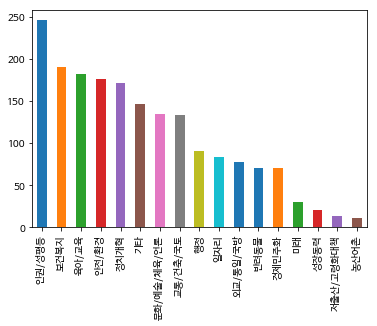

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'NanumBarunGothic'
category_count.plot(kind='bar')

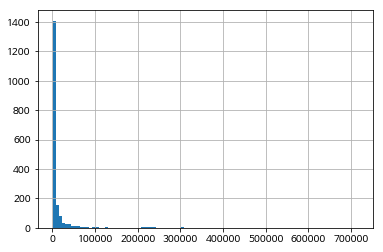

In [10]:
df['votes'].hist(bins=100)

In [11]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [12]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리


In [13]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = 7
sample_index

7

In [14]:
sample_title = df['title'][sample_index]
sample_title

'소액주주를 보호해주십시오'

In [15]:
sample_content = petitions['content'][sample_index]
sample_content

'**  존경하옵는 문재인대통령님께\\n저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니다. 중국원양자원(이하 중원)은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고 있습니다.\\n상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수 있습니다.\\n결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 및 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다.\\n이로인해 약 2만 5천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다.\\n주식투자는 개인의 판단하에 이루어지는 것이나 투자에 대한 개인의 책임을 묻기전에 그 과정은 규정과 상식에 맞게 공정하고 정의로워야 할 것입니다. 이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템, 특히 거래소와 회계감사는 그렇지 못한 것 같습니다.\\n이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다\\n이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 많은 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고 있습니다. .\\n기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 대한 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야 합니다.\\n그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의\'결정적 이유\'로 명시하였는바 이는 감사자의 \'의견거절\'에 따른 참혹한 결과로 볼때 

# 전처리 하기 

In [16]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [17]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '그', '있는', '있습니다','년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [18]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [19]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [20]:
pre_sample_content

'    존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니다  중국원양자원 이하 중원 은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고  상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수  결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다  이로인해 약  만  천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다  주식투자는 개인의 판단하에 이루어지는 것이나 투자에 개인의 책임을 묻기전에 과정은 규정과 상식에 맞게 공정하고 정의로워야 것입니다  이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템  특히 거래소와 회계감사는 그렇지 못한 것  이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다 이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고    기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야  그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의 결정적 이유 로 명시하였는바 이는 감사자의  의견거절 에 따른 참혹한 결과로 볼때      명의 국민들과 가족들은 공정한 감사결과라 절대로 인정할수  고통의 원인은 법 제도나 규정에 근거를 두지 않

In [21]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 264 ms, sys: 8.1 ms, total: 272 ms
Wall time: 296 ms


In [22]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 468 ms, sys: 11.3 ms, total: 479 ms
Wall time: 526 ms


# 기계학습으로 기타 제거하기
* 기타로 분류된 청원중에 특정 카테고리로 분류해 주면 좀 더 정확도가 높아질 것이라는 가설을 세워봅니다.
* 따라서 기타로 분류된 청원을 다른 청원을 바탕으로 학습시켜 분류해 봅니다.

In [23]:
df['category_pred'] = df['category'].copy()

In [24]:
df_not_etc = df.loc[df['category'] != '기타'].copy()
df_etc = df.loc[df['category'] == '기타'].copy()
print(df_not_etc.shape)
print(df_etc.shape)

(1698, 11)
(146, 11)


## 기타 청원 분류하기 벡터화
* tfidf 를 사용해 벡터화 

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 9), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 9), preprocessor=None,
        stop_words=['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜', '같은', '같습니다', '없습니다', '위해', '한다'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [27]:
%%time 
df_not_etc_vector = vectorizer.fit_transform(df_not_etc['content_preprocessing2'])
df_not_etc_vector.shape

CPU times: user 18.8 s, sys: 1.09 s, total: 19.9 s
Wall time: 21.7 s


In [28]:
%%time 
df_etc_vector = vectorizer.fit_transform(df_etc['content_preprocessing2'])
df_etc_vector.shape

CPU times: user 1.62 s, sys: 68.4 ms, total: 1.68 s
Wall time: 1.69 s


In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [30]:
%%time 
df_not_etc_tfidf = transformer.fit_transform(df_not_etc_vector)
df_not_etc_tfidf.shape

CPU times: user 5.38 ms, sys: 3.19 ms, total: 8.57 ms
Wall time: 7.51 ms


In [31]:
%%time 
df_etc_tfidf = transformer.fit_transform(df_etc_vector)
df_etc_tfidf.shape

CPU times: user 2.58 ms, sys: 1.6 ms, total: 4.18 ms
Wall time: 2.57 ms


## 기타 청원 분류하기

In [32]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [33]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_not_etc['category']
%time forest = forest.fit(df_not_etc_tfidf, y_label)

CPU times: user 2.67 s, sys: 58.1 ms, total: 2.73 s
Wall time: 950 ms


In [34]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(df_etc_tfidf)
y_pred[:3]

array(['인권/성평등', '외교/통일/국방', '교통/건축/국토'], dtype=object)

In [35]:
df_etc['category_pred'] = y_pred
df_etc['category_pred'].value_counts()

육아/교육          38
인권/성평등         31
안전/환경          17
보건복지           15
정치개혁           14
경제민주화          10
교통/건축/국토       10
일자리             5
외교/통일/국방        2
문화/예술/체육/언론     2
반려동물            2
Name: category_pred, dtype: int64

## 기타 청원 분류 결과의 일부를 미리보기

In [36]:
df_etc[['votes', 'title', 'content', 'category', 'category_pred']].head(10)

,votes,title,content,category,category_pred
345,1126,문재인 대통령 기념 시계도 판매하라.,문재인 대통령 싸인이 들어간 기념 시계를 판매용으로 전환하여 주세요. SNS상의 국...,기타,인권/성평등
487,2749,2017년 10월 원천세 신고기한 및 9월분 전자세금계산서 발행기한일을 10월 13...,2017년 추석연휴 및 10월 2일 임시공휴일 지정이 확정됨에 따라 10월 초에 법...,기타,외교/통일/국방
12747,1841,억울한죽음으로 돌아가신 고 이길연집배원의 순직을요구합니다,9월5일 서광주우체국에 근속중이신 고 이길연집배원 저희아버지가 자택에서 홀로목숨을끈...,기타,교통/건축/국토
15456,1705,화훼도매시장 출입에 대한 출입증 발급을 청원합니다,화훼쪽에 종사하고 있는 사람입니다\n김영란법이 터지고 나서 뉴스를 보면 양재화훼시장...,기타,인권/성평등
17150,1078,TNS홀딩스 강태욱 대표 사기 횡령 사건 해결을 부탁드립니다.,안녕하세요\n영등포구에 거주하는 30살 직장인입니다.\n2014년부터 알고지낸 재무...,기타,육아/교육
19072,123530,'일간베스트'사이트를 폐지해주세요,"국민들을 불편하게하고, 주변에 민폐를 끼치기로 유명한 일베는 사회적이슈로도 자주 떠...",기타,안전/환경
22162,2452,경찰들의 성교육 이수 및 가중처벌,최근 경찰의 성폭행 성추행 성희롱등 그 주체가 범죄를 다루고 있는 경찰이된 사건들이...,기타,인권/성평등
22375,2684,튜닝카 법 개정,차량튜닝에대한 법 개정이 필요할것같습니다. 요즘 튜닝사업이 확대되는 시대 입니다. ...,기타,안전/환경
22551,2278,을지대학교병원지부 노동조합 파업사태 해결 촉구,"문재인 대통령께\n안녕하세요 대통령님, 저는 대전 을지대학교병원에 근무하는 병원노동...",기타,보건복지
23292,1470,우리나라 법은 도대체 누구를 위한 법입니까 법 개선과 피해자를 위한 제도마련이 필요...,안녕하세요 .\n오늘도 국민들을 위해 나라에 힘써주시느라 너무나 고생이 많으십니다....,기타,육아/교육


## 기타 카테고리로 분류한 데이터를 다시 합쳐 줍니다. 

In [37]:
df2 = pd.concat([df_not_etc, df_etc])
df2.shape

(1844, 11)

In [38]:
df2['category_pred'].value_counts()

인권/성평등         277
육아/교육          220
보건복지           205
안전/환경          193
정치개혁           185
교통/건축/국토       143
문화/예술/체육/언론    136
행정              91
일자리             88
경제민주화           80
외교/통일/국방        79
반려동물            72
미래              30
성장동력            20
저출산/고령화대책       14
농산어촌            11
Name: category_pred, dtype: int64

# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [39]:
df2.shape

(1844, 11)

In [40]:
split_count = int(df2.shape[0] * 0.7)
split_count

1290

In [41]:
df_train = df2[:split_count].copy()
df_train.shape

(1290, 11)

In [42]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [43]:
df_train['content_preprocessing2'].head(50)

7           존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21      대통령님  안녕하세요  임용을 준비하고 수험생입니다  처음 기간제 정규직화 된다고 ...
24      대통령님  안녕하세요  임용을 준비하고 수험생입니다  처음 기간제 정규직화 된다고 ...
28      안녕하십니까  대통령님 간단하게 제소개 부터 하겠습니다  치위생과  학년 학생입니다...
38         영전강의고용안정을 원합니다    년단위계약직으로 임신 출산육아 매우 곤란합니다...
46        대 초반에 수능 다시 공부해서 교대에 다니고 교대생입니다  회사에 다니다 교사의...
48      대통령님께서 대선 후보이시던 시절 충격적인 기사를 접했습니다  영양사 단체 행사에서...
52      기회의 사다리이자 가장 공정한 수능 상대평가 유지와 정시확대를 원합니다 사걱세나 전...
66      문재인정부 출범    일을 맞이하는 기자회견이   청와대에서 열리고 지지율은 여전히...
81      중등학교 현직교사입니다  중등교사 가티오를  본 후 충격을 받고 글을 쓰게 되었습니...
83      이명박 정부에서는 영어회화전문강사  스포츠 강사 제도를 만들었습니다  영어와 체육의...
88      여가부 산하 해바라기센터 심리치료사의 부적절한 자격 요건 에 규정 수정 강화가 필요...
90      이명박 정부에서는 영어회화전문강사  스포츠 강사 제도를 만들었습니다  영어와 체육의...
102     대통령님 취임 이후 어려운 상황 속에서도 원만한 국정 운영을 해 주신 점 국민의 사...
261     안녕하세요  현재 서울시민이자 직장생활   년 만에 첫 내집을 경기도 구리에 장만하...
315     먼져 대통령님 이하 여러 장관님들 국민들 피땀흘리시느라 정말 고생이 많으십니다  다...
359     안녕하십니까  대통령님 현재 경기도체육회 내 시군체육회 소속에 생활체육지도자 저희가...
360     기회는 평등

In [44]:
df_test = df2[split_count:].copy()
df_test.shape

(554, 11)

In [45]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
169200,209713,2018-04-23,2018-05-23,0,1045,일자리,학습지회사들의 다단계적 업무횡포 / 갑질 철저히 조사해주시기 바랍니다.,안녕하세요.\n학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 30대 남성입니...,일자리,안녕하세요 학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 대 남성입니다...,안녕하세요 학습지 회사에 근무하고 와이프를 둔 일반 직장인 대 남성입니다 요...
169240,209760,2018-04-23,2018-05-23,0,1631,일자리,카드사 '갑'질 때문에 일자리 잃게 생겼어요,안녕하세요 ‘카드기단말기’ 설치 회사에 근무하는 사람입니다.\n카드 가맹점 가입 절...,일자리,안녕하세요 카드기단말기 설치 회사에 근무하는 사람입니다 카드 가맹점 가입 절차...,안녕하세요 카드기단말기 설치 회사에 근무하는 사람입니다 카드 가맹점 가입 절차...
169422,209990,2018-04-23,2018-05-23,0,3084,정치개혁,혜경궁김씨에 대한 검찰과 경찰의 적극적 수사를 촉구합니다.,"20여일전에 트위터에서 발생했던 소위 ""혜경궁김씨""에 대한\n경찰과 검찰의 적극적이...",정치개혁,여일전에 트위터에서 발생했던 소위 혜경궁김씨 에 대한 경찰과 검찰의 적극적이고...,여일전에 트위터에서 발생했던 소위 혜경궁김씨 에 경찰과 검찰의 적극적이고 조속...
169433,210001,2018-04-23,2018-05-23,0,2464,교통/건축/국토,7호선은 경기북부의 생명선 입니다.,10년이 넘는 세월동안\n피땀어린 눈물로 7호선 유치에\n경기북부의 시민들은 온힘을...,교통/건축/국토,년이 넘는 세월동안 피땀어린 눈물로 호선 유치에 경기북부의 시민들은 온힘을 쏟...,년이 넘는 세월동안 피땀어린 눈물로 호선 유치에 경기북부의 시민들은 온힘을 쏟...
169459,210030,2018-04-23,2018-05-23,0,8190,보건복지,중증환자 5년지원 이상 연장,안녕하세요.\n저는 8년전 유방암진단받고 아직도 복약 및 투병중입니다.\n처음 암에...,보건복지,안녕하세요 저는 년전 유방암진단받고 아직도 복약 및 투병중입니다 처음 암에 걸...,안녕하세요 년전 유방암진단받고 아직도 복약 투병중입니다 처음 암에 걸리면 ...


## 카테고리 

* 예측한 카테고리의 비율을 봅니다.

In [46]:
df_category_value = pd.DataFrame(df2['category_pred'].value_counts())
df_category_percent = pd.DataFrame(df2['category_pred'].value_counts(normalize=True))
df_category = df_category_value.merge(df_category_percent, left_index=True, right_index=True)
df_category.columns = ['청원수', '청원비율']
df_category

,청원수,청원비율
인권/성평등,277,0.150217
육아/교육,220,0.119306
보건복지,205,0.111171
안전/환경,193,0.104664
정치개혁,185,0.100325
교통/건축/국토,143,0.077549
문화/예술/체육/언론,136,0.073753
행정,91,0.049349
일자리,88,0.047722
경제민주화,80,0.043384


## 학습데이터의 카테고리

In [47]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category = df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)
df_train_category.columns = ['청원수', '청원비율']
df_train_category

,청원수,청원비율
인권/성평등,164,0.127132
보건복지,154,0.119380
육아/교육,143,0.110853
안전/환경,131,0.101550
정치개혁,119,0.092248
문화/예술/체육/언론,119,0.092248
교통/건축/국토,104,0.080620
행정,67,0.051938
일자리,66,0.051163
외교/통일/국방,56,0.043411


## 테스트 데이터의 카테고리

In [48]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category = df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)
df_test_category.columns = ['청원수', '청원비율']
df_test_category

,청원수,청원비율
기타,146,0.263538
인권/성평등,82,0.148014
정치개혁,52,0.093863
안전/환경,45,0.081227
육아/교육,39,0.070397
보건복지,36,0.064982
교통/건축/국토,29,0.052347
행정,24,0.043321
외교/통일/국방,21,0.037906
경제민주화,19,0.034296


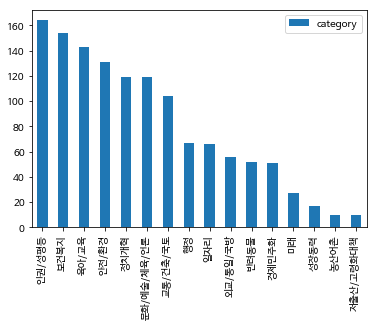

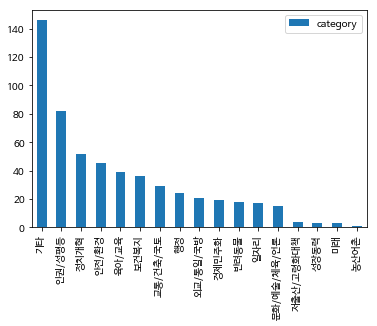

In [49]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜', '같은', '같습니다', '없습니다', '위해', '한다'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [51]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 3.42 s, sys: 55 ms, total: 3.48 s
Wall time: 3.48 s


In [52]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 1.62 s, sys: 26.4 ms, total: 1.65 s
Wall time: 1.65 s


In [53]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'articleview',
 'articleview idxno',
 'be',
 'cd',
 'co',
 'co kr',
 'co kr news',
 'com',
 'com main']

In [54]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,articleview,articleview idxno,be,cd,co,co kr,co kr news,com,com main,...,후에도,훨씬,휴게시간,휴게시간을,희망을,힘든,힘들게,힘들어,힘을,힘이
0,41,45,45,100,94,49,165,37,35,21,...,45,29,74,43,23,21,23,22,52,34


In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [56]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 5.33 ms, sys: 2.2 ms, total: 7.53 ms
Wall time: 5.69 ms


In [57]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 3.65 ms, sys: 1.93 ms, total: 5.58 ms
Wall time: 4.06 ms


In [58]:
test_feature_tfidf.shape

(554, 2000)

In [59]:
from collections import Counter
dict(Counter(vocab).most_common(30))

{'aid': 1,
 'articleview': 1,
 'articleview idxno': 1,
 'be': 1,
 'cd': 1,
 'co': 1,
 'co kr': 1,
 'co kr news': 1,
 'com': 1,
 'com main': 1,
 'com main read': 1,
 'com news': 1,
 'com view': 1,
 'daum': 1,
 'daum net': 1,
 'do': 1,
 'http': 1,
 'http media': 1,
 'http media daum': 1,
 'http news': 1,
 'http news naver': 1,
 'http www': 1,
 'https': 1,
 'https www': 1,
 'https youtu': 1,
 'https youtu be': 1,
 'id': 1,
 'idxno': 1,
 'it': 1,
 'kc인증': 1}

## 예측한 카테고리를 label로 사용하기

In [60]:
# 학습에 사용할 y_label 을 넣어줍니다. 기타를 제거한 카테고리 데이터를 사용합니다.
y_label = df_train['category_pred']

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [61]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [62]:
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 1.78 s, sys: 47.8 ms, total: 1.83 s
Wall time: 745 ms


## XGBoost로 학습시키기

In [63]:
import xgboost as xgb

# XGBoost Parameters http://xgboost.readthedocs.io/en/latest/parameter.html
xgb = xgb.XGBClassifier(n_estimators=10,
                          max_depth=6,
                          learning_rate=1.0,
                          max_delta_step=1,
                          eta = 1,
                          nthread=-1,
                          seed=2018)
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, gamma=0, learning_rate=1.0,
       max_delta_step=1, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2018, silent=True, subsample=1)

In [64]:
%time xgb.fit(train_feature_tfidf, y_label)

CPU times: user 5.54 s, sys: 218 ms, total: 5.76 s
Wall time: 1.77 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, gamma=0, learning_rate=1.0,
       max_delta_step=1, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=-1, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2018, silent=True, subsample=1)

# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면, 
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

## RF 평가

In [65]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

CPU times: user 141 ms, sys: 46.9 ms, total: 188 ms
Wall time: 2.74 s


array([0.47286822, 0.41472868, 0.44186047, 0.40697674, 0.41860465])

In [66]:
round(np.mean(score)*100,2)

43.1

## xgb 평가

In [67]:
%time score_xgb = cross_val_score(xgb, train_feature_tfidf, y_label, scoring="accuracy").mean()
print(round(np.mean(score_xgb)*100,2))

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 10.3 s, sys: 689 ms, total: 11 s
Wall time: 4.56 s
33.43


/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 예측
## RF

In [68]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['인권/성평등', '인권/성평등', '육아/교육'], dtype=object)

In [69]:
y_pred.shape

(554,)

## XGB

In [70]:
y_pred_xgb = xgb.predict(test_feature_tfidf)

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [71]:
print(y_pred_xgb.shape)
df_test['category_pred_xgb'] = y_pred_xgb
y_pred_xgb[:5]

(554,)


array(['육아/교육', '보건복지', '육아/교육', '인권/성평등', '안전/환경'], dtype=object)

In [72]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,인권/성평등
1,인권/성평등
2,육아/교육
3,경제민주화
4,안전/환경


### RF로 예측한 카테고리

In [73]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었
output['category_pred'].value_counts()

육아/교육          179
안전/환경           94
보건복지            67
인권/성평등          62
문화/예술/체육/언론     46
교통/건축/국토        30
정치개혁            26
반려동물            19
외교/통일/국방        13
경제민주화           11
일자리              5
미래               2
Name: category_pred, dtype: int64

### XGB로 예측한 카테고리

In [74]:
df_test['category_pred_xgb'].value_counts()

인권/성평등         109
육아/교육           93
안전/환경           84
문화/예술/체육/언론     63
보건복지            55
정치개혁            47
교통/건축/국토        42
반려동물            19
경제민주화           15
일자리             12
행정               9
외교/통일/국방         5
미래               1
Name: category_pred_xgb, dtype: int64

In [75]:
df_test['category_pred'] = y_pred

In [76]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head(3)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff
169200,209713,2018-04-23,2018-05-23,0,1045,일자리,학습지회사들의 다단계적 업무횡포 / 갑질 철저히 조사해주시기 바랍니다.,안녕하세요.\n학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 30대 남성입니...,인권/성평등,안녕하세요 학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 대 남성입니다...,안녕하세요 학습지 회사에 근무하고 와이프를 둔 일반 직장인 대 남성입니다 요...,육아/교육,0
169240,209760,2018-04-23,2018-05-23,0,1631,일자리,카드사 '갑'질 때문에 일자리 잃게 생겼어요,안녕하세요 ‘카드기단말기’ 설치 회사에 근무하는 사람입니다.\n카드 가맹점 가입 절...,인권/성평등,안녕하세요 카드기단말기 설치 회사에 근무하는 사람입니다 카드 가맹점 가입 절차...,안녕하세요 카드기단말기 설치 회사에 근무하는 사람입니다 카드 가맹점 가입 절차...,보건복지,0
169422,209990,2018-04-23,2018-05-23,0,3084,정치개혁,혜경궁김씨에 대한 검찰과 경찰의 적극적 수사를 촉구합니다.,"20여일전에 트위터에서 발생했던 소위 ""혜경궁김씨""에 대한\n경찰과 검찰의 적극적이...",육아/교육,여일전에 트위터에서 발생했던 소위 혜경궁김씨 에 대한 경찰과 검찰의 적극적이고...,여일전에 트위터에서 발생했던 소위 혜경궁김씨 에 경찰과 검찰의 적극적이고 조속...,육아/교육,0


In [77]:
df_test['pred_diff_xgb'] = 0
df_test['pred_diff_xgb'] = (df_test['category'] == df_test['category_pred_xgb'] ) == 1
df_test['pred_diff_xgb'] = df_test['pred_diff_xgb'].astype(int)
df_test.head(3)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
169200,209713,2018-04-23,2018-05-23,0,1045,일자리,학습지회사들의 다단계적 업무횡포 / 갑질 철저히 조사해주시기 바랍니다.,안녕하세요.\n학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 30대 남성입니...,인권/성평등,안녕하세요 학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 대 남성입니다...,안녕하세요 학습지 회사에 근무하고 와이프를 둔 일반 직장인 대 남성입니다 요...,육아/교육,0,0
169240,209760,2018-04-23,2018-05-23,0,1631,일자리,카드사 '갑'질 때문에 일자리 잃게 생겼어요,안녕하세요 ‘카드기단말기’ 설치 회사에 근무하는 사람입니다.\n카드 가맹점 가입 절...,인권/성평등,안녕하세요 카드기단말기 설치 회사에 근무하는 사람입니다 카드 가맹점 가입 절차...,안녕하세요 카드기단말기 설치 회사에 근무하는 사람입니다 카드 가맹점 가입 절차...,보건복지,0,0
169422,209990,2018-04-23,2018-05-23,0,3084,정치개혁,혜경궁김씨에 대한 검찰과 경찰의 적극적 수사를 촉구합니다.,"20여일전에 트위터에서 발생했던 소위 ""혜경궁김씨""에 대한\n경찰과 검찰의 적극적이...",육아/교육,여일전에 트위터에서 발생했던 소위 혜경궁김씨 에 대한 경찰과 검찰의 적극적이고...,여일전에 트위터에서 발생했던 소위 혜경궁김씨 에 경찰과 검찰의 적극적이고 조속...,육아/교육,0,0


In [78]:
# RF로 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    507
1     47
Name: pred_diff, dtype: int64

In [79]:
# XGB로 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff_xgb = df_test['pred_diff_xgb'].value_counts()
pred_diff_xgb

0    495
1     59
Name: pred_diff_xgb, dtype: int64

In [80]:
print('RF 전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

RF 전체 554건의 데이터 중 47건 예측


In [81]:
print('XGB 전체 {}건의 데이터 중 {}건 예측'.format(y_pred_xgb.shape[0], pred_diff_xgb[1]))

XGB 전체 554건의 데이터 중 59건 예측


In [82]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 8.483754512635379


In [83]:
acc = ( pred_diff_xgb[1] / y_pred_xgb.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 10.649819494584838


In [84]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
169873,210558,2018-04-24,2018-05-24,0,1122,보건복지,집앞 패기물 처리장 왜? 건재한가요?,국민의 한 사람이자 남양주의 한 시민 으로써 처음으로 청원 게시판에 글을 올립니다....,보건복지,국민의 한 사람이자 남양주의 한 시민 으로써 처음으로 청원 게시판에 글을 올립니다 ...,국민의 사람이자 남양주의 시민 으로써 처음으로 청원 게시판에 글을 올립니다 년...,보건복지,1,1
171132,212170,2018-04-25,2018-05-25,0,78934,보건복지,"말기암 암 환자의 마지막 희망, 면역항암제 급여화와 적응증 확대해주세요",저희 엄마는 말기 암 환자입니다.\n병원에서 호스피스를 권유 받았었고\n실오라기 같...,보건복지,저희 엄마는 말기 암 환자입니다 병원에서 호스피스를 권유 받았었고 실오라기 같은 ...,저희 엄마는 말기 암 환자입니다 병원에서 호스피스를 권유 받았었고 실오라기 희망으...,보건복지,1,1
171201,212254,2018-04-25,2018-05-25,0,8477,문화/예술/체육/언론,박지훈 번역가의 작품(번역)참여를 반대합니다,지금까지 영화에서 수많은 오역과 발번역을 하여 각종 비난과 퇴출운동이 일어나고 있는...,문화/예술/체육/언론,지금까지 영화에서 수많은 오역과 발번역을 하여 각종 비난과 퇴출운동이 일어나고 있는...,지금까지 영화에서 수많은 오역과 발번역을 하여 각종 비난과 퇴출운동이 일어나고 문제...,문화/예술/체육/언론,1,1
171961,213223,2018-04-27,2018-05-27,0,15318,반려동물,강아지공장 및 펫숍 운영 금지,반려동물을 키우시는 분들이나 동물에 관심이 있으신 분들이라면 누구나 한번쯤 들어봤을...,반려동물,반려동물을 키우시는 분들이나 동물에 관심이 있으신 분들이라면 누구나 한번쯤 들어봤을...,반려동물을 키우시는 분들이나 동물에 관심이 있으신 분들이라면 누구나 한번쯤 들어봤을...,반려동물,1,1
173437,215212,2018-04-29,2018-05-29,0,2173,반려동물,성동구청 길고양이 어울쉼터 철거.이전 반대합니다,2017년2월14일 강동구청 성안별관 옥상에 3개월 미만의 고양이나 돌봄이 필요한 ...,반려동물,년 월 일 강동구청 성안별관 옥상에 개월 미만의 고양이나 돌봄이 필요한 ...,년 강동구청 성안별관 옥상에 개월 미만의 고양이나 돌봄이 필요한 다친 고...,반려동물,1,1


In [85]:
predict_incorrect = df_test.loc[df_test['pred_diff_xgb'] == 0].copy()
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
169200,209713,2018-04-23,2018-05-23,0,1045,일자리,학습지회사들의 다단계적 업무횡포 / 갑질 철저히 조사해주시기 바랍니다.,안녕하세요.\n학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 30대 남성입니...,인권/성평등,안녕하세요 학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 대 남성입니다...,안녕하세요 학습지 회사에 근무하고 와이프를 둔 일반 직장인 대 남성입니다 요...,육아/교육,0,0
169240,209760,2018-04-23,2018-05-23,0,1631,일자리,카드사 '갑'질 때문에 일자리 잃게 생겼어요,안녕하세요 ‘카드기단말기’ 설치 회사에 근무하는 사람입니다.\n카드 가맹점 가입 절...,인권/성평등,안녕하세요 카드기단말기 설치 회사에 근무하는 사람입니다 카드 가맹점 가입 절차...,안녕하세요 카드기단말기 설치 회사에 근무하는 사람입니다 카드 가맹점 가입 절차...,보건복지,0,0
169422,209990,2018-04-23,2018-05-23,0,3084,정치개혁,혜경궁김씨에 대한 검찰과 경찰의 적극적 수사를 촉구합니다.,"20여일전에 트위터에서 발생했던 소위 ""혜경궁김씨""에 대한\n경찰과 검찰의 적극적이...",육아/교육,여일전에 트위터에서 발생했던 소위 혜경궁김씨 에 대한 경찰과 검찰의 적극적이고...,여일전에 트위터에서 발생했던 소위 혜경궁김씨 에 경찰과 검찰의 적극적이고 조속...,육아/교육,0,0
169433,210001,2018-04-23,2018-05-23,0,2464,교통/건축/국토,7호선은 경기북부의 생명선 입니다.,10년이 넘는 세월동안\n피땀어린 눈물로 7호선 유치에\n경기북부의 시민들은 온힘을...,경제민주화,년이 넘는 세월동안 피땀어린 눈물로 호선 유치에 경기북부의 시민들은 온힘을 쏟...,년이 넘는 세월동안 피땀어린 눈물로 호선 유치에 경기북부의 시민들은 온힘을 쏟...,인권/성평등,0,0
169459,210030,2018-04-23,2018-05-23,0,8190,보건복지,중증환자 5년지원 이상 연장,안녕하세요.\n저는 8년전 유방암진단받고 아직도 복약 및 투병중입니다.\n처음 암에...,안전/환경,안녕하세요 저는 년전 유방암진단받고 아직도 복약 및 투병중입니다 처음 암에 걸...,안녕하세요 년전 유방암진단받고 아직도 복약 투병중입니다 처음 암에 걸리면 ...,안전/환경,0,0


In [86]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

기타             146
인권/성평등          67
정치개혁            46
안전/환경           36
육아/교육           28
보건복지            28
교통/건축/국토        27
행정              24
외교/통일/국방        21
경제민주화           18
일자리             16
문화/예술/체육/언론     14
반려동물            13
저출산/고령화대책        4
성장동력             3
미래               3
농산어촌             1
Name: category, dtype: int64

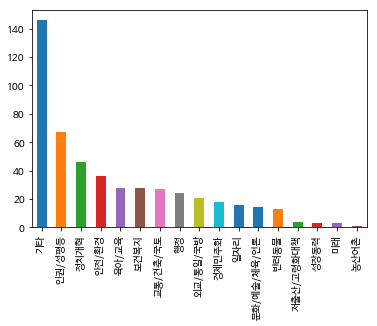

In [87]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [88]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
169200,일자리,인권/성평등,학습지회사들의 다단계적 업무횡포 / 갑질 철저히 조사해주시기 바랍니다.,안녕하세요.\n학습지 회사에 근무하고 있는 와이프를 둔 일반 직장인 30대 남성입니...
169240,일자리,인권/성평등,카드사 '갑'질 때문에 일자리 잃게 생겼어요,안녕하세요 ‘카드기단말기’ 설치 회사에 근무하는 사람입니다.\n카드 가맹점 가입 절...
169422,정치개혁,육아/교육,혜경궁김씨에 대한 검찰과 경찰의 적극적 수사를 촉구합니다.,"20여일전에 트위터에서 발생했던 소위 ""혜경궁김씨""에 대한\n경찰과 검찰의 적극적이..."
169433,교통/건축/국토,경제민주화,7호선은 경기북부의 생명선 입니다.,10년이 넘는 세월동안\n피땀어린 눈물로 7호선 유치에\n경기북부의 시민들은 온힘을...
169459,보건복지,안전/환경,중증환자 5년지원 이상 연장,안녕하세요.\n저는 8년전 유방암진단받고 아직도 복약 및 투병중입니다.\n처음 암에...
169514,경제민주화,안전/환경,주휴수당,주휴수당 있는나라는 우리밖에 없습니다 주휴수당을 없에주세요
169609,안전/환경,교통/건축/국토,피해자를 모욕하고 폭력을 옹호한 동두천 소방관 '파면' 바랍니다.,"“저거oo대녀 아니냐? 평생 소장급 야동임, 강추”라며 몰카 피해자를 모욕하고,\n..."
169643,안전/환경,정치개혁,세월호 희생자 수습에 힘쓴 민간 잠수사 지원에 대한 법안 통과를 촉구합니다.,세월호 희생자 수습에 힘쓴 민간 잠수사 지원에 대한 법안 통과를 촉구합니다.\n물론...
169738,반려동물,안전/환경,대학내 불법 동물실험을 규제 해주세요,국내 연구 기관에서 동물실험을 하기 위해서는 정해진 절차와 법률을 따르도록 되어 있...
169772,보건복지,육아/교육,흡연보행에 대한 시행령 및 법안 진행을 청원합니다.,서울시에서 2017년 5월에 온라인 정책 공론장 데모크라시서울을 통해 시민 제안을 ...


## 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 봅니다.

In [89]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
345,기타,보건복지,문재인 대통령 기념 시계도 판매하라.,문재인 대통령 싸인이 들어간 기념 시계를 판매용으로 전환하여 주세요. SNS상의 국...
487,기타,문화/예술/체육/언론,2017년 10월 원천세 신고기한 및 9월분 전자세금계산서 발행기한일을 10월 13...,2017년 추석연휴 및 10월 2일 임시공휴일 지정이 확정됨에 따라 10월 초에 법...
12747,기타,안전/환경,억울한죽음으로 돌아가신 고 이길연집배원의 순직을요구합니다,9월5일 서광주우체국에 근속중이신 고 이길연집배원 저희아버지가 자택에서 홀로목숨을끈...
15456,기타,육아/교육,화훼도매시장 출입에 대한 출입증 발급을 청원합니다,화훼쪽에 종사하고 있는 사람입니다\n김영란법이 터지고 나서 뉴스를 보면 양재화훼시장...
17150,기타,육아/교육,TNS홀딩스 강태욱 대표 사기 횡령 사건 해결을 부탁드립니다.,안녕하세요\n영등포구에 거주하는 30살 직장인입니다.\n2014년부터 알고지낸 재무...
19072,기타,보건복지,'일간베스트'사이트를 폐지해주세요,"국민들을 불편하게하고, 주변에 민폐를 끼치기로 유명한 일베는 사회적이슈로도 자주 떠..."
22162,기타,안전/환경,경찰들의 성교육 이수 및 가중처벌,최근 경찰의 성폭행 성추행 성희롱등 그 주체가 범죄를 다루고 있는 경찰이된 사건들이...
22375,기타,문화/예술/체육/언론,튜닝카 법 개정,차량튜닝에대한 법 개정이 필요할것같습니다. 요즘 튜닝사업이 확대되는 시대 입니다. ...
22551,기타,안전/환경,을지대학교병원지부 노동조합 파업사태 해결 촉구,"문재인 대통령께\n안녕하세요 대통령님, 저는 대전 을지대학교병원에 근무하는 병원노동..."
23292,기타,육아/교육,우리나라 법은 도대체 누구를 위한 법입니까 법 개선과 피해자를 위한 제도마련이 필요...,안녕하세요 .\n오늘도 국민들을 위해 나라에 힘써주시느라 너무나 고생이 많으십니다....


In [90]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 8.483754512635379


In [91]:
acc = ( pred_diff_xgb[1] / y_pred_xgb.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 10.649819494584838
